In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.inceptionv3 import inceptionv3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [4]:
# useful for getting number of output classes
folders = glob('train/*')

In [5]:
folders

['train\\Healthyplants',
 'train\\LowFertileAndLight',
 'train\\WeedType1',
 'train\\WeedType2',
 'train\\WeedType3',
 'train\\WeedType4']

In [6]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [8]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 ) # set as training data

Found 2445 images belonging to 6 classes.


In [15]:
valid_generator = train_datagen.flow_from_directory('val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            ) 

Found 813 images belonging to 6 classes.


In [16]:
test_generator = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False,
                                            ) 

Found 819 images belonging to 6 classes.


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [18]:
earlystopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [25]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator),
  callbacks = [earlystopper]
)

Epoch 1/20
77/77 [==============================] - 90s 1s/step - loss: 0.6122 - accuracy: 0.8581 - val_loss: 0.5399 - val_accuracy: 0.8807
Epoch 2/20
77/77 [==============================] - 51s 666ms/step - loss: 0.2372 - accuracy: 0.9378 - val_loss: 0.1952 - val_accuracy: 0.9545
Epoch 3/20
77/77 [==============================] - 52s 671ms/step - loss: 0.3000 - accuracy: 0.9317 - val_loss: 0.2653 - val_accuracy: 0.9373
Epoch 4/20
77/77 [==============================] - 51s 670ms/step - loss: 0.4311 - accuracy: 0.9186 - val_loss: 0.2688 - val_accuracy: 0.9434
Epoch 5/20
77/77 [==============================] - 52s 680ms/step - loss: 0.3190 - accuracy: 0.9460 - val_loss: 0.1480 - val_accuracy: 0.9606
Epoch 6/20
77/77 [==============================] - 53s 683ms/step - loss: 0.2179 - accuracy: 0.9571 - val_loss: 0.2578 - val_accuracy: 0.9508
Epoch 7/20
77/77 [==============================] - 53s 683ms/step - loss: 0.2333 - accuracy: 0.9501 - val_loss: 0.2249 - val_accuracy: 0.9471
Ep

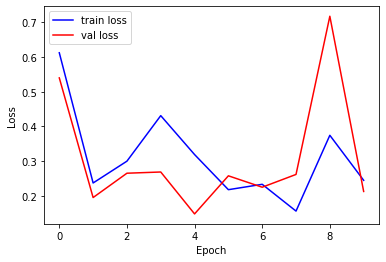

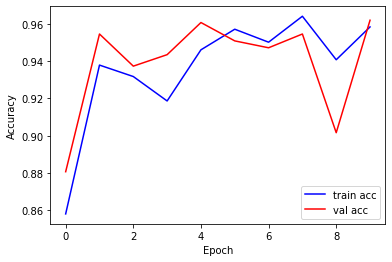

In [26]:
# plot the loss
plt.plot(r.history['loss'], 'b', label='train loss')
plt.plot(r.history['val_loss'], 'r', label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], 'b', label='train acc')
plt.plot(r.history['val_accuracy'], 'r', label='val acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

819/819 - 23s - loss: 0.1584 - accuracy: 0.9670
Test accuracy: 0.9670329689979553
Test loss: 0.15839585661888123


In [28]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc, roc_auc_score

In [29]:
test_generator.reset()
# get the ground truth of your data. 
y_true = test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# get the classification report
print(classification_report(y_true, y_pred))

819/819 - 15s
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       146
           1       0.97      0.92      0.94       191
           2       0.92      1.00      0.96        97
           3       1.00      0.97      0.99       105
           4       0.98      1.00      0.99       209
           5       1.00      0.90      0.95        71

    accuracy                           0.97       819
   macro avg       0.97      0.96      0.97       819
weighted avg       0.97      0.97      0.97       819



In [30]:
print(confusion_matrix(y_true, y_pred))

[[146   0   0   0   0   0]
 [  9 175   6   0   1   0]
 [  0   0  97   0   0   0]
 [  0   0   0 102   3   0]
 [  0   1   0   0 208   0]
 [  0   4   3   0   0  64]]


In [32]:
from sklearn.preprocessing import LabelBinarizer

In [34]:
 list(train_generator.class_indices.keys())

['Healthyplants',
 'LowFertileAndLight',
 'WeedType1',
 'WeedType2',
 'WeedType3',
 'WeedType4']

ROC AUC score: 0.9786604340225398


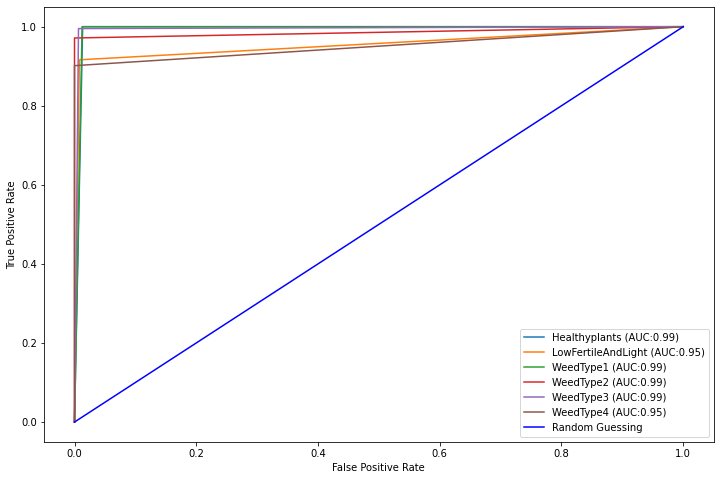

In [35]:
all_labels = ['Healthyplants', 'LowFertileAndLight', 'WeedType1', 'WeedType2', 'WeedType3' , 'WeedType4']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_true, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [37]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('PClogs/PCInception.h5')

test accuracy : 96.7032967032967


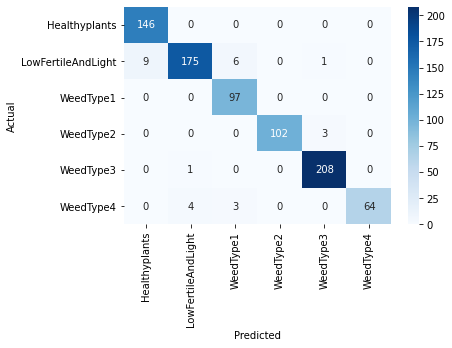

In [38]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('PClogs/PCInception.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_generator.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [3]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [4]:
model=load_model('PClogs/PCInception.h5')

In [5]:
img=image.load_img('test/WeedType3/WeedType3 (1000).jpg',target_size=(224,224))

In [6]:
x=image.img_to_array(img)

In [7]:
x=x/255

In [8]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [9]:
result = model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)

In [10]:
result

array([[6.0650209e-09, 1.6033187e-05, 2.3425304e-07, 1.4534070e-10,
        9.9998367e-01, 5.1033965e-08]], dtype=float32)

0 : 0.0000006065 %
1 : 0.0016033187 %
2 : 0.0000234253 %
3 : 0.0000000145 %
4 : 99.9983670000 %
5 : 0.0000051034 %
Predicted : WeedType3


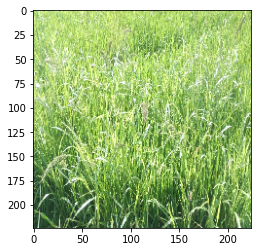

In [23]:
plt.imshow(img)
b = -1
for i in [6.0650209e-09, 1.6033187e-05, 2.3425304e-07, 1.4534070e-10,
        9.9998367e-01, 5.1033965e-08] :
    b = b + 1
    print(b, ':', '%0.10f'%(i*100),'%')
    
if(a==0):
    print("Predicted : Healthyplants")
elif(a==1):
    print("Predicted : LowFertileandLight")
elif(a==2):
    print("Predicted : WeedType1")
elif(a==3):
    print("Predicted : WeedType2")
elif(a==4):
    print("Predicted : WeedType3")
else:
    print("Predicted : WeedType4")